In [1]:
import pandas as pd
import math
import time

In [2]:
# feature selection type variables
FORWARD_SELECTION, BACKWARD_ELIMINATION = 'forward_selection', 'backward_elimination'

# cache to reduce the computational cost during measurement of euclidean distance
cache = {}

In [3]:
# given a file path of the dataset, method reads dataset
# and returns all the instances with their labels
# and feature count per instance
def read_dataset(dataset_path):

    data = pd.read_csv(dataset_path, delim_whitespace=True, header = None)
    instance_count, column_count = data.shape   
    feature_count = column_count - 1
    instances = data.values.tolist()
    
    return instances, instance_count, feature_count

In [4]:
# given two instances of the dataset, and a list of features to be considered
# method find the euclidean distance based on the features given
# the method uses a global cache to reduce the computational cost incurred
# to find the distance, whenever it finds two features, that are already stored
# in the map with its squared difference, the method gets the value from the map
# otherwise, it calculates the value and stores in the map for further usage
def find_euclidean_distance(instance, compare_instance, features):
    
    squares = 0
    # iterates over the given features
    for feature in features:
        
        x = instance[feature]
        y = compare_instance[feature]
        val = 0
        
        # searching if already the calculated value is in the cache
        if (x,y) in cache:
            val = cache[(x, y)]
        elif (y,x) in cache:
            val = cache[(y, x)]
        else:
            diff = x - y
            val = diff ** 2
            
            cache[(x, y)] = val
            
        squares += val
    
    return math.sqrt(squares)

In [5]:
# given the dataset and feature set to be considered
# method predicts the label of the instance and compares the predicted one with
# the given label using nearest neighbor classifier where k = 1
# method returns the ratio of count of correctly predicted instances and
# total instances
def find_nearest_neighbor(dataset, feature_set, instance_count):
    
    correct_prediction = 0
    # iterating over each of the instance
    for instance_idx in range(instance_count):
        
        # extracts the current instance
        instance = dataset[instance_idx]
        # extracts the label of the current instance
        target = instance[0]
        # the set of features to be considered
        features = feature_set 
        
        nearest_neighbor_distance = math.inf
        nearest_neighbor_predict = -1
        
        # iterates over each of the other instances in the dataset
        # to find which instance is more close in respect of euclidean 
        # distance
        for compare_idx in range(instance_count):
            
            if compare_idx != instance_idx:
                
                compare_instance = dataset[compare_idx]
                compare_target = compare_instance[0]
                distance = find_euclidean_distance(instance,
                                                  compare_instance,
                                                  features)
                
                if distance < nearest_neighbor_distance:
                        nearest_neighbor_distance = distance
                        nearest_neighbor_predict = compare_target
        
        # checking whether the predicted label matches the target label
        if nearest_neighbor_predict == target:
            correct_prediction += 1

    # returns the ratio of the count of correctly predicted instance and 
    # total instances    
    return correct_prediction / instance_count

In [6]:
import matplotlib.pyplot as plt

# plots a graph to show how accuracy gets affected by feature counts
def plot_graph(accuracy_map, search_type, dataset_size):
    
    x = []
    y = []
    for key in sorted(accuracy_map):
        x.append(key)
        y.append(accuracy_map[key])
        
    plt.plot(x, y)
    plt.xlabel('Feature Count')
    plt.ylabel('Accuracy')
    plt.title('' + search_type.upper() + ' Dataset ' + dataset_size)
    plt.show()

In [7]:
# given the instances and feature set to be considered,
# method iteratively leaves one instance, runs nearest neighbor classifier on
# the remaining instances, and finds the accuracy, that is how, the number of 
# validation set will be equal to the number of instance count
# returns the average of the accuracy over all the validation sets
def leave_one_out_cross_validation(instances, instance_count, feature_set):
    
    accuracy_list = []
    # iterates over each of the instances
    for k_fold_itr in range(0, instance_count):
        
        # prepares a dataset removing k_fold_itr th instance
        dataset = instances[ :k_fold_itr] + instances[k_fold_itr + 1: ]

        # runs nearest neighbor classifier to finds accuracy 
        accuracy = find_nearest_neighbor(dataset, feature_set, \
                                         instance_count - 1)
        
        # appendds the accuracy in a list
        accuracy_list.append(accuracy)
    
    # returns the average accuracy found
    return sum(accuracy_list)/instance_count

In [8]:
# given the type of feature selection type along with all the instances
# iterates over different sets of features (based on the type of feature 
# selection given)
# for each different set of feature, finds leave-one-out validation accuracy
# using nearest neighbor classifier (k = 1)
# prints the best accuracy with the best feature set
# returns the best accuracy to best feature set per level to plot graph 
def start_experiment(instances, instance_count, feature_count, \
                     search_type = FORWARD_SELECTION):
    
    print()
    print()
    print(search_type.upper())
    accuracy_map = {}
    
    all_feature_set = list(range(1, feature_count + 1))
    accuracy = leave_one_out_cross_validation(\
                    instances, instance_count, all_feature_set)
    print('Running nearest neighbor with all', feature_count, \
          'features, using leave-one-out evaluation',
         'with accuracy', '{:0.1f}%'.format(accuracy * 100))
    accuracy_map[len(all_feature_set)] = accuracy
    
    # starts with an empty feature set for forward selection
    # starts with all features for backward elimination
    if search_type == FORWARD_SELECTION:
        current_feature_set = []
    elif search_type == BACKWARD_ELIMINATION:
        current_feature_set = all_feature_set
    
    print()
    print('Beginning Search ')
    best_accuracy_feature_set = all_feature_set
    best_accuracy = accuracy
    
    # iterating over each of the level
    # on each level, either the count of features
    # equal to  (level count) (forward selection)
    # or (total feature count - level count) (backward elimination)
    for level in range(1, feature_count):
        
        print('On the ', str(level), 'th level of the search tree')
        level_wise_best_accuracy_feature_set = None
        level_wise_best_accuracy_feature = None
        level_wise_best_accuracy = 0
        
        # iterating over each of the features which can be added
        # or removed for feature selection/backward elimination
        # respectively
        for feature in range(1, feature_count + 1):
            
            if (feature not in current_feature_set and \
                search_type == FORWARD_SELECTION) or \
                (feature in current_feature_set and \
                 search_type == BACKWARD_ELIMINATION):
                
                if search_type == FORWARD_SELECTION:
                    feature_set = current_feature_set + [feature]
                elif search_type == BACKWARD_ELIMINATION:
                    feature_set = list(set(current_feature_set) - set([feature]))
                
                # finding leave one out cross validation accuracy
                accuracy = leave_one_out_cross_validation(\
                                instances, instance_count, \
                                feature_set)
                
                # sorting for displaying results in good manner
                feature_set.sort()
                feature_set_string = '{' + ','.join(str(f) \
                                                    for f in feature_set) + '}'
                print('\t Using features',  feature_set_string, 'accuracy is', \
                      '{:0.1f}%'.format(accuracy * 100) )
                
                # checks if current feature set provides the better accuracy
                # among the feature sets in the current level
                if accuracy > level_wise_best_accuracy:
                    level_wise_best_accuracy = accuracy
                    level_wise_best_accuracy_feature = feature
                    level_wise_best_accuracy_feature_set = feature_set
                    
        if search_type == FORWARD_SELECTION:
            current_feature_set.append(level_wise_best_accuracy_feature)
            add_remove_log = 'adding ' + 'feature ' + \
                str(level_wise_best_accuracy_feature)
        elif search_type == BACKWARD_ELIMINATION:
            current_feature_set = list(set(current_feature_set) - \
                                        set([level_wise_best_accuracy_feature]))
            add_remove_log = 'removing ' + 'feature ' + \
                              str(level_wise_best_accuracy_feature)
            
        
        level_wise_best_feature_set_string = '{' + ','.join(str(f) \
                            for f in level_wise_best_accuracy_feature_set) + '}'
        print('Feature set ', level_wise_best_feature_set_string, \
              ' was best. accuracy is', '{:0.1f}%'.format(\
                                level_wise_best_accuracy*100), add_remove_log )
        
        accuracy_map[len(level_wise_best_accuracy_feature_set)] = \
                                level_wise_best_accuracy
        print()
        
        # checks if current level accuracy is best among the so far
        # feature sets considered
        if level_wise_best_accuracy > best_accuracy:
            best_accuracy = level_wise_best_accuracy
            best_accuracy_feature_set = level_wise_best_accuracy_feature_set
    
    # displays the best accuracy calculated with the best feature set
    best_accuracy_feature_set_string = '{' + ','.join(str(f) \
                                for f in best_accuracy_feature_set) + '}'
    print('Finished search !!', 'The best feature subset is', \
                                best_accuracy_feature_set_string, \
             'which has an accuracy of', '{:0.1f}%'.format(best_accuracy*100) )
    
    return accuracy_map
    

Press 11 to run Forward Selection with small dataset
Press 12 to run Forward Selection with large dataset
Press 21 to run Backward Elimination with small dataset
Press 22 to run Backward Elimination with large dataset
Press any other key to exit
11
Forward Selection selected with small dataset


FORWARD_SELECTION
Running nearest neighbor with all 10 features, using leave-one-out evaluation with accuracy 72.3%

Beginning Search 
On the  1 th level of the search tree
	 Using features {1} accuracy is 67.4%
	 Using features {2} accuracy is 65.7%
	 Using features {3} accuracy is 69.7%
	 Using features {4} accuracy is 66.3%
	 Using features {5} accuracy is 71.0%
	 Using features {6} accuracy is 73.3%
	 Using features {7} accuracy is 76.3%
	 Using features {8} accuracy is 90.3%
	 Using features {9} accuracy is 69.7%
	 Using features {10} accuracy is 68.0%
Feature set  {8}  was best. accuracy is 90.3% adding feature 8

On the  2 th level of the search tree
	 Using features {1,8} accuracy is 88

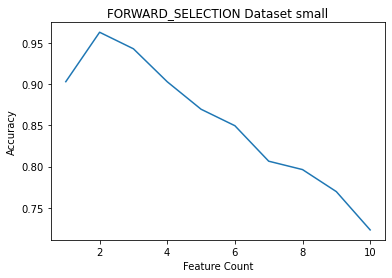

Execution time  11637.9 seconds




In [ ]:
# driver function
if __name__ == "__main__":
    
#     small_dataset_path = 'CS205_CalibrationData__1.txt'
    
    small_dataset_path = 'CS205_SP_2022_SMALLtestdata__35.txt'
    large_dataset_path = 'CS205_SP_2022_Largetestdata__62.txt'
    
    while True:

        input_case = input('Press 11 to run Forward Selection with small dataset\n' + \
                          'Press 12 to run Forward Selection with large dataset\n' + \
                          'Press 21 to run Backward Elimination with small dataset\n' + \
                          'Press 22 to run Backward Elimination with large dataset\n' + \
                          'Press any other key to exit\n').strip()
        
        start_time = time.time()
        
        if input_case == '11':
            print("Forward Selection selected with small dataset")
            instances, instance_count, feature_count = read_dataset(small_dataset_path)
            
            accuracy_map = start_experiment(instances, instance_count, \
                                            feature_count, FORWARD_SELECTION)
            plot_graph(accuracy_map, FORWARD_SELECTION, 'small')
                
        elif input_case == '12':
            print("Forward Selection selected with large dataset")
            instances, instance_count, feature_count = read_dataset(large_dataset_path)
            
            accuracy_map = start_experiment(instances, instance_count, \
                                            feature_count, FORWARD_SELECTION)
            plot_graph(accuracy_map, FORWARD_SELECTION, 'large')
            
            
        elif input_case == '21':
            print('Backward Elimination selected with small dataset')
            instances, instance_count, feature_count = read_dataset(small_dataset_path)
            
            accuracy_map = start_experiment(instances, instance_count, \
                                            feature_count, BACKWARD_ELIMINATION)
            plot_graph(accuracy_map, BACKWARD_ELIMINATION, 'small')
            
            
        elif input_case == '22':
            print('Backward Elimination selected with large dataset')
            
            instances, instance_count, feature_count = read_dataset(large_dataset_path)
            
            accuracy_map = start_experiment(instances, instance_count, \
                                            feature_count, BACKWARD_ELIMINATION)
            plot_graph(accuracy_map, BACKWARD_ELIMINATION, 'large')
            
            
        else:
            print('Exit. Thank you')
            break
        
        end_time = time.time()
        execution_time_in_seconds = end_time - start_time
        print('Execution time ', '{:0.1f} seconds'.format(execution_time_in_seconds))
        
        print()
        print()